In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb as choose
import math
import random

In [2]:
# given a list of counts of arbitrary phenotypes and scores for each phenotype
# return a list of the % the next population that weil have that phenotype as parent
def fittnessRatios(counts,scores,r):
    cutoffScore = max([scores[x] for x in range(len(scores)) if counts[x]>0])-r
    relScores = [x - cutoffScore if (x - cutoffScore > 0) else 0 for x in scores]    
    slices = np.multiply(counts,relScores);
    return [x/sum(slices) for x in slices]


# p = probabilty per draw, n = number of draws, x = do we get this many
def binomial(p,n,x):
    return choose(n,x) * (p**x) * ((1-p)**(n-x))


#
def i2j(i,j,mutRatePoint,theUP,lenGenome,mutCount):
    d = j-i        
    p_i2j = 0
    for x in range(math.ceil((mutCount-abs(d))/2)): 
        if d == 0:
            p_i2j += binomial(mutRatePoint,lenGenome,2*x)*binomial(theUP,2*x,x/2)
        elif d > 0:
            p_i2j += binomial(mutRatePoint,lenGenome,abs(d)+2*x)*binomial(theUP,abs(d)+2*x,abs(d)+x)
        elif d < 0:
            p_i2j += binomial(mutRatePoint,lenGenome,abs(d)+2*x)*binomial(1-theUP,abs(d)+2*x,abs(d)+x)
    return p_i2j


def neededMutations(maxTime,popSize,genomeSize,mutRatePoint):
    v = 1000
    i = 0
    while v > 1.0/(maxTime*popSize):
        v = binomial(mutRatePoint,genomeSize,i)
        i += 1
    return(i)


def printStatus(runTime, currTime, statusStep = -1):
    if statusStep == -1:
        statusStep = runTime/10
    if currTime % statusStep == 0 or currTime >= runTime:
        numSteps = int(runTime/statusStep)

        if currTime == 0:
            statusStr = '['
            for j in range(numSteps):
                statusStr+=' '
            statusStr += ']    0%'
            print(statusStr,end='')
        elif currTime>=runTime:
            statusStr = '\r['
            for j in range(numSteps):
                statusStr+='-'
            statusStr += ']  100%'
            print(statusStr)
        else:
            statusStr = '\r['
            for j in range(numSteps):
                if j < int(currTime/statusStep):
                    statusStr+='-'
                elif j == int(currTime/statusStep):
                    statusStr+='>'
                else:
                    statusStr+=' '
            statusStr+='] '
            percent = int(currTime/runTime * 100)
            if percent < 10:
                print(statusStr+'   '+str(percent)+'%',end='')
            else:
                print(statusStr+'  '+str(percent)+'%',end='')

In [24]:
#model parameters

slope_a = 0.1
period_a = 20 # in units of mutations (divide by 10 to match c++)

slope_b = -0.01
period_b = 5 # in units of mutations (divide by 10 to match c++)

numCycles = 30 #how many ascent&valley pairs are there in the transition matrix?

startCycle = 2 #which cycle do we start on? (set to 0 to match c++)

runTime = 100000 #generations basically
popSize = 100

scoreCutoff = 2 # selection pressure parameter
genomeSize = 10

mutRatePoint = .005
theUP = .5 #probability to mutate positive

First 2 Cycles:


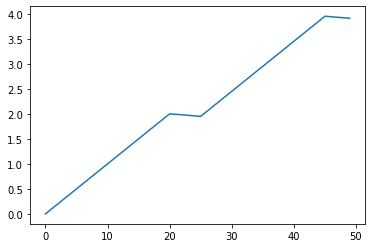

Mutation Matrix:


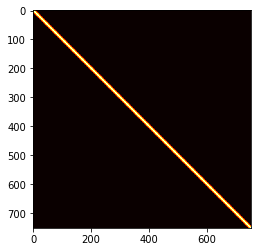

In [25]:
# fitness function build step

steps_per_cycle = period_a + period_b

# make a list of fitness deltas where each delta is "slope" and the length of the list is "period"
a = [slope_a]*period_a
# ditto above
b = [slope_b]*period_b 

crossConfirmation = math.ceil( abs(slope_b)*period_b/slope_a ) # how many mutations to be better than previous peak

nextEscape_L = lambda cycle: cycle*steps_per_cycle + crossConfirmation
nextPeak_L   = lambda cycle: cycle*steps_per_cycle + period_a

cycle = a+b #concatinate the two delta lists together to form one cycle (ascent&valley)
cycles = cycle * numCycles #multiply that by number of cycles to generate all deltas forever

# iterate over all deltas and add each one to the previous to build a fitness function
phenoScores = [0]
for delta in cycles:
    phenoScores.append(phenoScores[-1] + delta)

print("First 2 Cycles:")
plt.plot(phenoScores[:steps_per_cycle*2])
plt.show()
    
# mutation matrix build step
mutCount = neededMutations(runTime,popSize,genomeSize,mutRatePoint)*3

mutMatrix = np.zeros((len(phenoScores),len(phenoScores)))
for i in range (len(phenoScores)):
    for j in range (len(phenoScores)):
        mutMatrix[i][j] = i2j(i,j,mutRatePoint,theUP,genomeSize,mutCount)
        
print("Mutation Matrix:")
plt.imshow(np.log2(np.add(mutMatrix,10e-30)), cmap='hot', interpolation='nearest')
plt.show();

In [26]:
#init model (reset all starting values etc.)

startPhenoType = startCycle*steps_per_cycle #number of mutations offset from 0 to start run
nextEscape = nextEscape_L(startCycle + 1)
nextPeak = nextPeak_L(startCycle) # note the missing +1 is because the first nextPeak is in the current cycle

phenoCounts = [0]*len(phenoScores)
phenoCounts[startPhenoType] = 1
currentCycle = startCycle


# print('number of phonoTypes:',len(phenoCounts))
print('startPhenoType:',startPhenoType,'  startCycle:',startCycle)#,'  nextPeak:', nextPeak,'  nextEscape:', nextEscape)
# print('crossConfirmation:',crossConfirmation)
# print("will consider",mutCount,"mutations.")


# reset data collection structures
escapeTimes = []
peakTimes = []
phenoHistory = []

# run model
for t in range(runTime):
    printStatus(runTime, t, runTime/100)
    
    parentRatios = fittnessRatios(phenoCounts, phenoScores, scoreCutoff)
    phenoCounts = np.dot(parentRatios,mutMatrix)
    
#     phenoCountsActual = []
#     for c in phenoCounts:
#         c *= popSize
#         phenoCountsActual.append(int(c))
#         whatsLeft = c - phenoCountsActual[-1]
#         if whatsLeft > .000001 and whatsLeft > random.random():
#             phenoCountsActual[-1]+=1

    rawParents = [c*popSize for c in phenoCounts]
    intParents = list(map(int,rawParents))
    remParents = [p[0]-p[1] for p in list(zip(rawParents,intParents))]
    int_rem = list(zip(intParents,remParents))
    phenoCountsActual = [p[0]+1 if not np.isclose([p[1]],[0]) and p[1] > random.random() else p[0] for p in int_rem]
    
    
    phecoCountsSum = sum(phenoCountsActual)
    phenoCounts = [x/phecoCountsSum for x in phenoCountsActual]

    phenoHistory.append(phenoCounts)
        
    if sum(phenoCountsActual[nextEscape:]) > 1:
        escapeTimes.append(t)
        currentCycle += 1
        nextEscape = nextEscape_L(currentCycle + 1)
        print('\nescape time:',t,'  new cycle:',currentCycle)#,'  next escape phenotype:',nextEscape)

    if sum(phenoCountsActual[nextPeak:]) > 1:
        peakTimes.append(t)
        nextPeak = nextPeak_L(currentCycle + 1)
        print('\npeak time:',t)#,'  next peak phenotype:',nextPeak)

printStatus(runTime,runTime,runTime/100)
print("DONE")

startPhenoType: 50   startCycle: 2
[                                                                                                    ]    0%
peak time: 191

escape time: 220   new cycle: 3

peak time: 406

escape time: 508   new cycle: 4

peak time: 705

escape time: 805   new cycle: 5

peak time: 973
[->                                                                                                  ]    1%
escape time: 1120   new cycle: 6

peak time: 1267

escape time: 1400   new cycle: 7

peak time: 1551

escape time: 1596   new cycle: 8

peak time: 1751

escape time: 1892   new cycle: 9
[-->                                                                                                 ]    2%
peak time: 2123

escape time: 2260   new cycle: 10

peak time: 2430

escape time: 2608   new cycle: 11

peak time: 2770

escape time: 2850   new cycle: 12
[--->                                                                                                ]    3%
peak time: 3064

escape ti

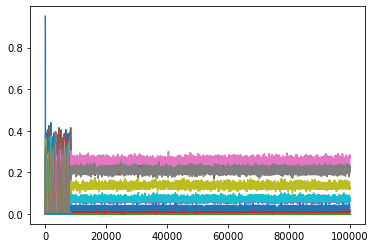

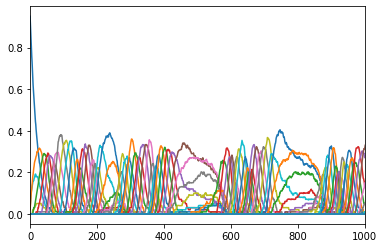

In [27]:
# view run history

# transpose data
phenoHistory_T = list(zip(*phenoHistory))

#plot all data
for i in range(len(phenoCounts)):
    plt.plot(phenoHistory_T[i],label = phenoScores[i])
plt.show()

# plot early history
for i in range(len(phenoCounts)):
    plt.plot(phenoHistory_T[i],label = phenoScores[i])
plt.xlim(0,1000)
plt.show()

28 27
[(191, 220), (406, 508), (705, 805), (973, 1120), (1267, 1400), (1551, 1596), (1751, 1892), (2123, 2260), (2430, 2608), (2770, 2850), (3064, 3129), (3351, 3472), (3673, 3744), (3914, 4073), (4225, 4283), (4434, 4602), (4793, 4934), (5107, 5298), (5488, 5634), (5797, 5908), (6074, 6223), (6380, 6517), (6681, 6826), (7011, 7198), (7397, 7515), (7709, 7834), (8000, 8100)]
[(220, 406), (508, 705), (805, 973), (1120, 1267), (1400, 1551), (1596, 1751), (1892, 2123), (2260, 2430), (2608, 2770), (2850, 3064), (3129, 3351), (3472, 3673), (3744, 3914), (4073, 4225), (4283, 4434), (4602, 4793), (4934, 5107), (5298, 5488), (5634, 5797), (5908, 6074), (6223, 6380), (6517, 6681), (6826, 7011), (7198, 7397), (7515, 7709), (7834, 8000), (8100, 8289)]
Average Escape Time: 121.62962962962963
Average Ascent Time: 178.2962962962963


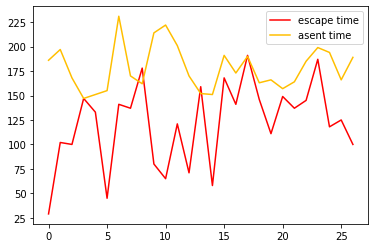

Percent Time Escape 0.008221680876979293


In [28]:
#post-process data

print(len(peakTimes),len(escapeTimes))


P2E = list(zip(peakTimes,escapeTimes)) #makes a pair of (P,E) 
E = [p[1]-p[0] for p in P2E] # computes E-P for all pairs
E_ave = sum(E)/len(E) # averages all of the E-P

print(P2E)

E2P = list(zip(escapeTimes,peakTimes[1:])) #makes a pair of (E,P), P starts at 1 not 0
P = [p[1]-p[0] for p in E2P] # computes P-E for all pairs
P_ave = sum(P)/len(P) # averages all P-E

print(E2P)

print("Average Escape Time:", E_ave)
print("Average Ascent Time:", P_ave)

plt.plot(E, color=(1,0,0), label='escape time')
plt.plot(P, color=(1,0.75,0), label='asent time')
plt.legend()
plt.show()

percent_escape = (1/E_ave)
print("Percent Time Escape", percent_escape)